# Recurrent Neural Networks and LSTM

지금껏 한 NN은 입력이 하나고 출력이 하나인 경우에 해당한다.  
RNN은 입력과 출력이 모두 여러 개인 경우를 위한 NN이다.

## Sequence Labeling
순차적 데이터 구조
- $x=(x_1, ..., x_T)$: 입력 벡터, $1~T$ 시간에 걸쳐 각 __시간마다__ 벡터가 입력된다.
- $y=(y_1,...,y_T)$: 출력 벡터. 각 시간대 마다 입력의 분류 결과인 출력 레이블이 나온다. 즉 각 시간마다 별도로 분류 작업을 수행한다.
- $\Omega = \{l_1, ...,l_L\}$: 클래스 레이블 집합

이를 해결하기 위해 일단 같은 NN을 모든 시간대마다 사용하며, 각 시간마다 그때의 외부 입력에 대해 분류 작업을 수행한다. 
- 그런데 각 시간 $t$마다 2가지의 입력을 받는다.
    1. $t-1$ 시점의 예측을 담당한 NN의 은닉층의 출력: $h^{(t-1)}$
    2. 그리고 $t$ 시간에 들어오는 외부 입력 $X^{(t)}$
- 모든 시간에선 동일한 구조의 NN을 사용한다.

## RNN의 구조(RNN architecture)

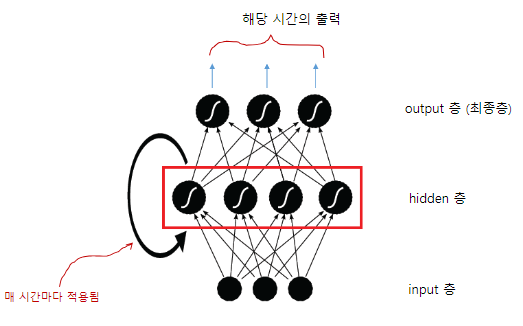

바로 전 시간의 은닉층의 출력 신호를 모은 벡터가 입력으로 들어간다.

외부 입력 $x$ 뿐만 아니라 전 시간의 은닉층의 출력 신호인 $h$들도 완전연결되어 입력된다. 이를 통해 이전 시점의 정보를 받아 Context도 고려한 추론을 할 수 있다(Sequential processing, 순차적 처리).

### Forward Computation

일반 NN에서 시간 순서 개념이 추가되었다고 보면 된다.

$$
a^t_h = \sum_{i=1}^I w_{ih}x_i^t + \sum_{h'=1}^H w_{h'h}b^{t-1}_{h'}+\beta_h \\
b^t_h =\theta_h(a_h^t) \\
a^t_k = \sum_{h=1}^H w_{hk}b^t_h + \beta_k
$$

> 여기서:  
> $b$ 는 $\theta$에 의해 활성화된 값이다.  
> $a^t_k$는 출력층의 $t$번째 시점에 대한 가중합이다.  
> 맨 처음 NN에선 받을 값이 없어서 애초에 은닉층의 출력을 0으로 받은 걸로 한다.

### Objective function: 학습 목표

손실함수(loss function) $L$을 최적화한다. 최적화 문제에서 이렇게 최적화 목표가 되는 함수를 목표함수라고 하고, NN에서 목표함수는 손실함수이다. 그리고 손실은 작을수록 좋으므로 최소화 문제가 된다(minimization).

이 손실함수는 NN의 파라미터(weights, bias)들을 입력변수로 가진다. 그래서 손실함수의 최적화를 위해선 그레디언트(미분값)이 필요하다.

RNN에선 매 시간마다 분류가 일어나므로 매 시간마다 손실이 나온다. 
- 시간 $t$에서의 $L_t$: 시간 $t$의 출력층에서 나오는 출력벡터와 target 벡터에 의한 cross entropy로 한다. 시간 $t$에서의 target label을 $d^t$라고 하고, 그 라벨에 대해 모델에서 출력된 확률을 $y^t_{d^t}$라고 하자.
$$
\text{Cross Entropy at t: }L_t = \ln{\frac{1}{y^t_{d^t}}}=-\ln{y^t_{d^t}}
$$
> 최소화 문제이기 때문에 음수를 사용, 절대값이 커질수록 좋은 것

- 결국 전체 손실은 모든 시간의 손실 $L_t$를 합하여 구한다.
$$
\text{Total Loss }L=L_1+L_2+ \cdots +L_T = \sum_{t=1}^T(-\ln{y^t_{d^t}})
$$

### Backward computation: gradient 계산

시간 t에 대한 출력층의 뉴런 K의 $\delta$ 구하기:
- $a^t_k$는 오직 $L_t$에만 영향을 준다.
- $\delta^t_k = y^t_k - 1_{k==d^t}$ <font color='red'>(eq1)</font>
    - $y^t_k$는 시간 $t$에서 뉴런 $k$의 소프트맥스 출력,
    - $d^t$는 시간 $y$에서의 정답 레이블이다.
        - 정답 레이블에 해당하면 거기서 출력된 확률에서 1을 뺀다.

은닉층 뉴런 $h$의 $\delta$구하기:
1. 같은 시간의 출력층의 뉴런들을 통해 손실함수에 영향
2. 다음 시간, 즉 $t+1$의 은닉층의 뉴런들을 통해 손실함수에 영향  
따라서 은닉층 뉴런은 자신이 영향을 준 뉴런들로부터 역전파를 받는다.
$$
\delta^t_h = \theta'(a^t_h)\left(\sum_{k=1}^K \delta^t_k w_{hk} + \sum^H_{h'=1}\delta^{t+1}_{h'}w_{hh'} \right),\\
\text{where }\delta^t_j \equiv \frac{\partial L}{\partial a^t_j}
$$
<font color = 'red'>(eq2)</font>

## Backpropagation through time algorithm: BPTT

- 앞의 eq2를 보면 시간 t에서 hidden 층 뉴론의 δ는 시간 t+1의 hidden 층의 δ에 의존
  - 따라서 나중 시간대의 δ를 먼저 계산한 후 그 이전 시간의 δ를 계산해야 한다.
  - 결론: t=T에서 먼저 gradients를 계산하고, t=T-1에서 gradients를 계산하고, ... 와 같이 시간 상 역순으로 계산해 나가야 한다.

### BPTT algorithm for RNN:
1. Set $δ_h^{T+1} = 0, \forall h$;
2. For $t = T, T-1, ..., 1$ do:
   - Compute all $δ_k^t$ using eq1;
   - Compute all $δ_h^t$ using eq2;
3. Compute gradients of all parameters; (다음 장에서 설명).
4. Update parameters;


## 파라미터 gradient 구하기: weights w

- 3 종류의 weights가 있음:
  - **case1**: $w_{i,h}$: 입력신호에서 hidden 층 neuron으로 가는 신호의 weight,
  - **case2**: $w_{h,k}$: hidden 뉴론에서 output 층 뉴론의 가는 신호의 weight,
  - **case3**: $w_{h',h}$: hidden 층 뉴론에서 (다음 시간의) hidden 층 뉴론으로 가는 신호의 weight.

---

- **주**: 일반 NN에서 유도한 다음 사실을 이용한다: 

  $$
  \frac{\partial L}{\partial W_{r,j}^n} = \delta_j^n f_r^{n-1}
  $$

- 위 모든 경우를 한 가지로 구할 수 있다:
  - 주어진 weight를 $ w_{i,j} $라고 하자.
  - 이 weight는 뉴런 $ j $를 통해서만 loss에 영향을 준다.
  - 그런데 여러 시간대마다 뉴런 $ j $에 영향을 준다.
  - 즉 objective function을 $ L(a_j^1, ...,a^T_j) $라는 완전함수로 보아 **chain-rule**에 이용하자.

  $$
  \frac{\partial L(a_j^1, ...,a^T_j)}{\partial w_{i,j}} = \sum_{t=1}^{T} \frac{\partial L}{\partial a^t_j} \frac{\partial a_j^t}{\partial w_{i,j}} = \sum_{t=\tau}^{n} \delta_j^t \frac{\partial a_j^t}{\partial w_{i,j}}
  $$

  - 여기서 $ a_j^t $는 $ w_{i,j} $의 종류에 따라 다르다.

---

- $\frac{\partial a_j^t}{\partial w_{i,j}}$ 구하기:
  - **case-1**: $ \frac{\partial a_j^h}{\partial w_{i,h}} = x_i^t $
  - **case-2**: $ \frac{\partial a_k^t}{\partial w_{h,k}} = b_h^t $
  - **case-3**: $ \frac{\partial a_h^t}{\partial w_{h',h}} = b_h^{t-1}$


## 파라미터 gradient 구하기: bias $\beta$

은닉층 뉴런의 편향을 예시로 들자: $\beta_h$  
한 뉴런의 가중합: 
$$
a_h^t = \sum_{i=1}^{I-1}w_{i,h}x_i^t + \sum_{h'=0}^{H-1}w_{h'h}b_{h'}^{t-1}+\beta_h
$$ 

따라서:
$$
\frac{\partial a_h^t}{\partial \beta_h}=1
$$

$$
\therefore\ \frac{\partial L}{\partial \beta_h} = \frac{\partial L(a_h^0 , ..., a_h^{T-1})}{\partial \beta_h} = \sum_{t=1}^T \frac{\partial L}{\partial a_h^t}\frac{\partial a_h^t}{\partial \beta_h} \\
= \sum_{t=1}^T \delta_h^t \frac{\partial a_h^t}{\partial \beta_h}\\
=\sum_{t=1}^T \delta_h^t \quad \square
$$

# Bidirectional RNN

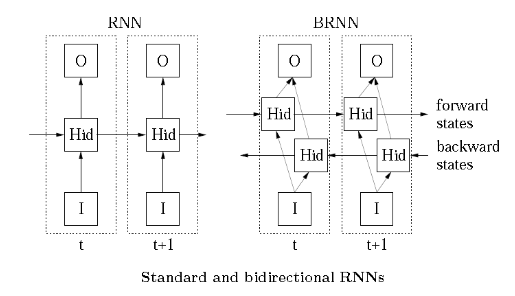

이전 시간의 은닉층에서 나온 은닉상태(Hidden state)를 현재 시간에서 받아서 쓰는 걸 문맥정보(context)를 이용한다고도 한다.

BRNN은 양방향으로 은닉상태를 받는다. 과거의 은닉정보뿐만 아니라 미래의 은닉정보도 사용하는 것이다.

과거의 정보를 순방향 은닉상태(forward hidden states), 미래의 정보를 역방향 은닉상태(backward hidden states)라고 한다.

여기서도 마찬가지로 각각의 뉴런들은 전부 완전연결이다. 하지만 뉴런의 개수에 따라 신호의 차원이 바뀌는 것도 동일해서 잘 파악해야 한다.  

입력층에서 오는 신호가 500개, 이전 시간에서 받는 은닉상태가 100개면 현재 시간의 순방향 은닉층은 600개의 신호를 처리한다.

**Algorithm 3.1: BRNN Forward Pass**

```
for t = 1 to T do
    Do forward pass for the forward hidden layer, storing activations at each timestep
for t = T to 1 do
    Do forward pass for the backward hidden layer, storing activations at each timestep
for t = 1 to T do
    Do forward pass for the output layer, using the stored activations from both hidden layers
```

---

**Algorithm 3.2: BRNN Backward Pass**

```
for t = T to 1 do
    Do BPTT backward pass for the output layer only, storing δ terms at each timestep(이것은 시간과  상관이 없다.)
for t = T to 1 do
    Do BPTT backward pass for the forward hidden layer, using the stored δ terms from the output layer
for t = 1 to T do
    Do BPTT backward pass for the backward hidden layer, using the stored δ terms from the output layer
```

## Vanishing Gradient problem for RNNs

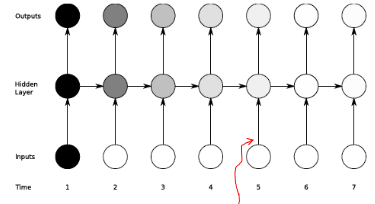

RNN은 첫 시간에서 받은 값이 계속 가중치가 곱해지며 다음 시간으로 보내진다. 그런데 가중치가 1 미만이면 그 값이 점점 작아져 버린다. 이로 인해 과거의 정보를 은닉상태를 통해 넘겨받은 것의 의미가 옅어진다.

이러한 문제는 입력 시퀀스의 길이가 길수록 심해진다.

# LSTM

## LSTM memory block

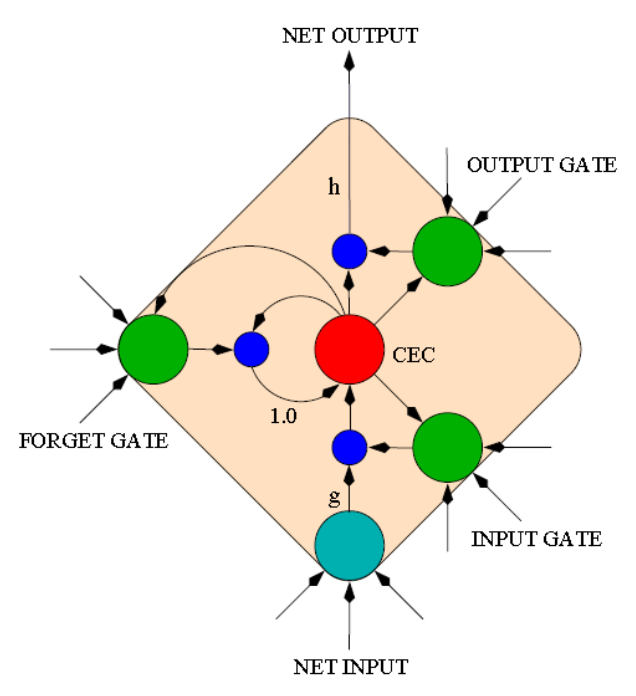

**NET INPUT** : 입력 벡터 $x$를 바로 받는 곳
- 기존의 뉴런과 동일한 구조

3개의 게이트:
- Input
- Output
- Forget

입력 벡터들:
- 시간 $t$에서의 외부 입력 벡터
- $h^{t-1}$: 이전 시간대의 은닉층의 활성화 벡터
- $s^{t-1}$: 이전 시간대의 셀의 값(스칼라)

Input gate에서 Net input의 출력값에 0과 1사이의 값을 곱해 셀(CEC)로 들어가는 값을 조정한다.

셀에서는 이전 시간의 셀 상태$(s^{t-1})$와 망각 게이트의 출력을 곱한 것을 받아 상태를 업데이트한다.

$$
s^t = g \cdot f_1 + s^{t-1} \cdot f_2
$$

최종 출력이 나가기 전 출력 게이트의 값과 곱하여 값을 조정한다.

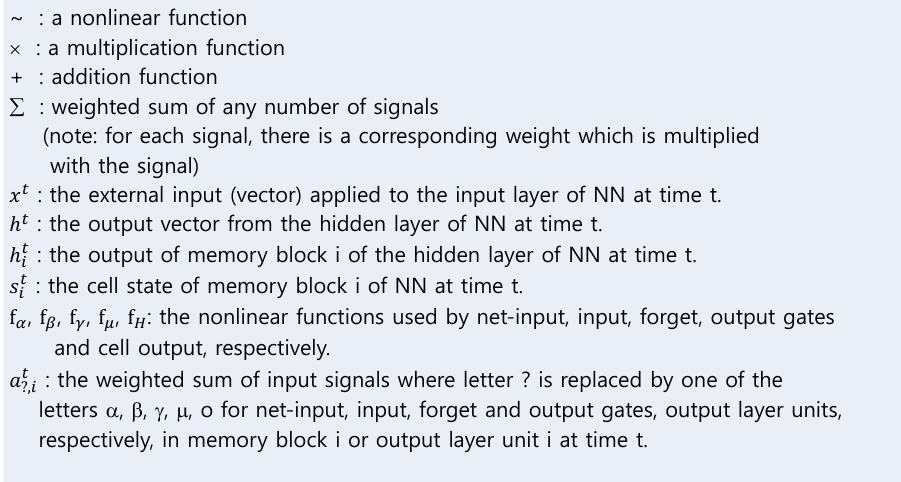

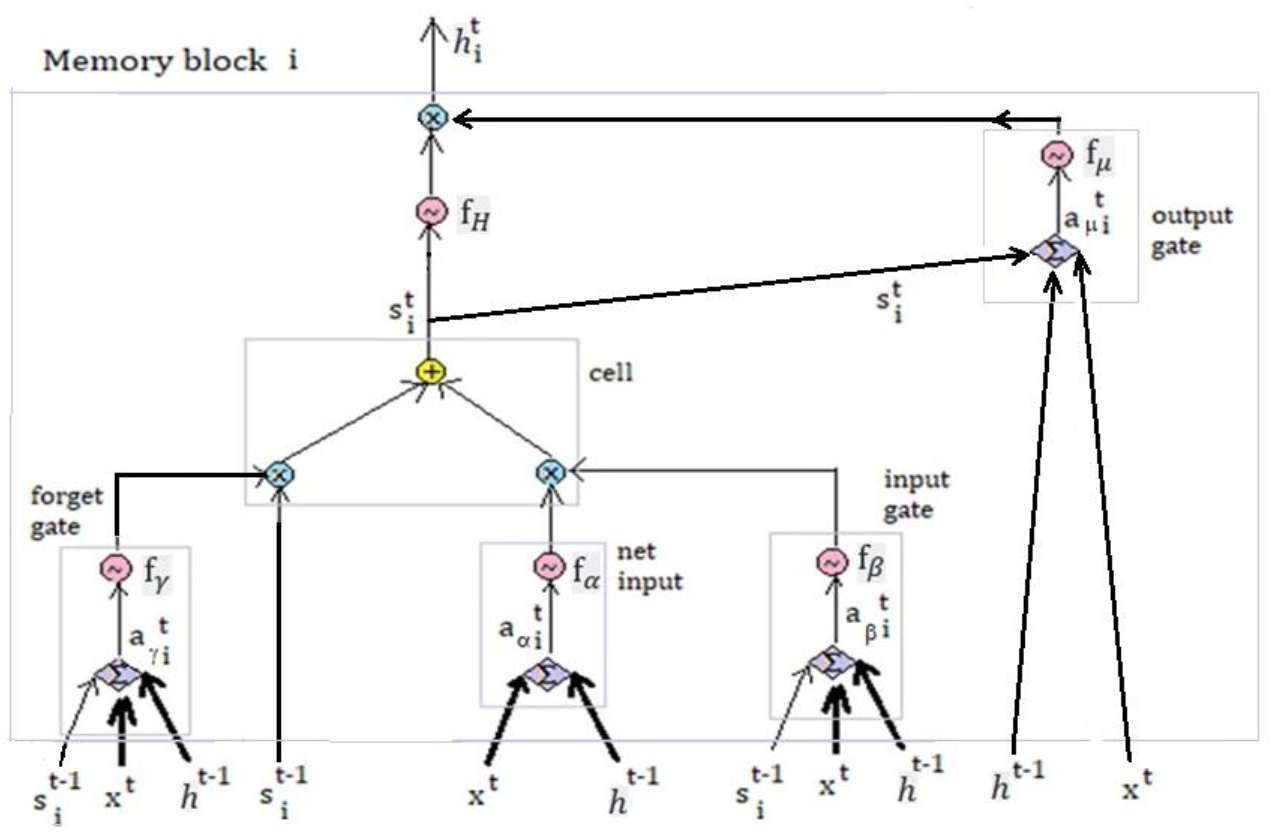

## Parameters of LSTM

| 가중치 및 편향 설명 | 기호 |
|----------------------|------|
| 입력층에서 순입력, 망각, 입력, 출력 게이트로의 가중치 행렬 (i: 입력층 유닛, j: 메모리 블록) | $w_{ij}^{x\alpha}, w_{ij}^{x\gamma}, w_{ij}^{x\beta}, w_{ij}^{x\mu}$ |
| 이전 시점 t-1에서 현재 시점 t로의 순입력, 망각, 입력, 출력 게이트로의 가중치 행렬 (i: 은닉 유닛, j: 메모리 블록) | $w_{ij}^{h\alpha}, w_{ij}^{h\gamma}, w_{ij}^{h\beta}, w_{ij}^{h\mu}$ |
| t-1 시점에서 t 시점으로의 상태에 대한 입력 및 망각 게이트로의 가중치 벡터 (i: 블록 인덱스) | $w_{i}^{s\beta}, w_{i}^{s\gamma}$ |
| t 시점에서 출력 게이트로 가는 t 시점의 셀 상태에 대한 입력 가중치 벡터 (i: 블록 인덱스) | $w_{i}^{s\mu}$ |
| 순입력, 입력 게이트, 망각 게이트, 출력 게이트의 편향 (i: 블록 인덱스) | $b_{i}^{\alpha}, b_{i}^{\gamma}, b_{i}^{\beta}, b_{i}^{\mu}$ |
| 은닉층에서 출력층으로의 가중치 행렬 및 출력 유닛의 편향 | $w_{j}^{ho}, b_{j}^{o}$ |

## Forward pass At time t


---

입력층, 은닉층, 출력층의 유닛(레이어 크기) 수를 각각 $z_x$, $z_h$, $z_o$로 나타냅니다.  
$o^t$는 t 시점에서 출력 벡터를 나타내며, $o_i^t$는 해당 벡터의 i번째 요소입니다.  
출력층 유닛은 선형 활성화 함수를 사용합니다.  
소프트맥스 계산은 $o^t$를 사용하여 수행되며, 그 결과는 벡터 $y^t$에 저장됩니다.

1. **순입력(Net-inputs)**:  
   $$
   a_{\alpha,i}^t = \sum_{k=1}^{z_x} w_{k,i}^{x\alpha} x_k^t + \sum_{k=1}^{z_h} w_{k,i}^{h\alpha} h_k^{t-1} + b_i^{\alpha}
   $$  
   (식 4)

2. **입력 게이트(Input gates)**:  
   $$
   a_{\beta,i}^t = \sum_{k=1}^{z_x} w_{k,i}^{x\beta} x_k^t + \sum_{k=1}^{z_h} w_{k,i}^{h\beta} h_k^{t-1} + w_i^{s\beta} s_i^{t-1} + b_i^{\beta}
   $$  
   (식 1)

3. **망각 게이트(Forget gates)**:  
   $$
   a_{\gamma,i}^t = \sum_{k=1}^{z_x} w_{k,i}^{x\gamma} x_k^t + \sum_{k=1}^{z_h} w_{k,i}^{h\gamma} h_k^{t-1} + w_i^{s\gamma} s_i^{t-1} + b_i^{\gamma}
   $$  
   (식 2)

4. **출력 게이트(Output gates)**:  
   $$
   a_{\mu,i}^t = \sum_{k=1}^{z_x} w_{k,i}^{x\mu} x_k^t + \sum_{k=1}^{z_h} w_{k,i}^{h\mu} h_k^{t-1} + w_i^{s\mu} s_i^t + b_i^{\mu}
   $$  
   (식 3)

5. **셀 상태(States of cells)**:  
   $$
   s_i^t = f_{\gamma}(a_{\gamma,i}^t) s_i^{t-1} + f_{\beta}(a_{\beta,i}^t) f_{\alpha}(a_{\alpha,i}^t)
   $$  
   (식 5)

6. **은닉층 유닛(Hidden layer units)**:  
   $$
   h_i^t = f_{\mu}(a_{\mu,i}^t) f_{H}(s_i^t)
   $$  
   (식 6)

7. **출력층 유닛(Output layer units)**:  
   $$
   o_i^t = a_{o,i}^t = \sum_{k=1}^{z_h} w_{k,i}^{ho} h_k^t + b_i^o \quad (\text{출력 유닛에 선형 함수를 사용함})
   $$  
   (식 7)

8. **소프트맥스 계산(Softmax computation)**:  
   $$
   y_i^t = \frac{e^{o_i^t}}{\sum_{k=1}^{z_o} e^{o_k^t}}
   $$  
   (식 8)

---

## Backward pass equations at time t

---

### 1. 목적 함수 정의
- **목적 함수 $ L $**: 클래스 인덱스 $ d^t $에 대한 레이블을 사용하여 정의된 **로그 손실 함수**입니다.
  $$
  L = -\ln \prod_{t=1}^T y_{d^t}^t = -\sum_{t=1}^T \ln y_{d^t}^t
  $$
  여기서 $ y_{d^t}^t $는 $ t $ 시점에서 정답 클래스 $ d^t $에 대한 예측 확률입니다.

### 2. 예측 확률 정의
- **소프트맥스 출력 $ y_i^t $**: $ i $-번째 클래스의 출력 확률로, 소프트맥스 활성화 함수에 의해 계산됩니다.
  $$
  y_i^t = \frac{e^{o_i^t}}{\sum_{k=1}^{z_o} e^{o_k^t}}
  $$
  여기서 $ o_i^t $는 $ i $-번째 클래스의 로짓(출력 점수)입니다.

### 3. 손실 함수 $ L $의 표현
- 손실 $ L $을 로그 손실 함수의 성질을 사용해 다음과 같이 변형합니다:
  $$
  L = \sum_{t=1}^T \left( -a_{o, d^t}^t + \ln \sum_{j=1}^{z_o} e^{a_{o, j}^t} \right)
  $$
  여기서 $ a_{o, i}^t $는 $ i $-번째 클래스에 대한 점수(로짓)입니다.

### 4. 역전파에서의 그레이디언트 계산
- **그레이디언트 $ \delta_{o, i}^t $**: 손실 $ L $에 대해 $ a_{o, i}^t $에 대한 그레이디언트를 구합니다.
  $$
  \delta_{o, i}^t \equiv \frac{\partial L}{\partial a_{o, i}^t} = \frac{\partial}{\partial a_{o, i}^t} \left( -a_{o, d^t}^t + \ln \sum_{j=1}^{z_o} e^{a_{o, j}^t} \right)
  $$
  이를 전개하면 다음과 같은 결과를 얻습니다:
  $$
  \delta_{o, i}^t = -1_{i = d^t} + \frac{e^{o_i^t}}{\sum_{k=1}^{z_o} e^{o_k^t}} = -1_{i = d^t} + y_i^t
  $$
  - $ -1_{i = d^t} $는 $ i = d^t $일 때 -1을, 그렇지 않으면 0을 나타내는 지표 함수입니다.
  - $ y_i^t $는 소프트맥스 활성화로 얻은 예측 확률입니다.

---

### 요약
- **손실 함수** $ L $: 시점별 로그 손실의 합.
- **소프트맥스 출력** $ y_i^t $: 각 클래스의 예측 확률.
- **그레이디언트** $ \delta_{o, i}^t $: 손실에 대해 각 클래스 로짓의 그레이디언트를 계산하여, 정답 클래스와 예측 확률의 차이로 표현됩니다.

이러한 수식을 통해 **역전파** 시 각 로짓에 대해 그레이디언트를 계산하여 파라미터를 업데이트할 수 있습니다.

---

### 은닉층에서의 역전파

#### 은닉상태의 그레디언트

$$
\epsilon_{h, i}^t = \frac{\partial C}{\partial h_i^t} = \frac{\partial C (a^{t}_{o}, a_{\alpha}^{t+1}, a_{\beta}^{t+1}, a_{\gamma}^{t+1}, a_{\mu}^{t+1})}{\partial h_i^t}
$$

$$
= \sum_{j=1}^{z_o} \frac{\partial C}{\partial a^t_{o, j}} \frac{\partial a^t_{o, j}}{\partial h_i^t} + \sum_{j=1}^{z_n} \frac{\partial C}{\partial a_{\alpha, j}^{t+1}} \frac{\partial a_{\alpha, j}^{t+1}}{\partial h_i^t} \\+ \sum_{j=1}^{z_n} \frac{\partial C}{\partial a_{\beta, j}^{t+1}} \frac{\partial a_{\beta, j}^{t+1}}{\partial h_i^t} + \sum_{j=1}^{z_n} \frac{\partial C}{\partial a_{\gamma, j}^{t+1}} \frac{\partial a_{\gamma, j}^{t+1}}{\partial h_i^t} + \sum_{j=1}^{z_n} \frac{\partial C}{\partial a_{\mu, j}^{t+1}} \frac{\partial a_{\mu, j}^{t+1}}{\partial h_i^t}
$$


$$
= \sum_{j=1}^{z_o} \delta_{o, j}^{t+1} W_{ij}^{ho} + \sum_{j=1}^{z_n} \delta_{\alpha, j}^{t+1} W_{ij}^{h\alpha} + \sum_{j=1}^{z_n} \delta_{\beta, j}^{t+1} W_{ij}^{h\beta} \\+ \sum_{j=1}^{z_n} \delta_{\gamma, j}^{t+1} W_{ij}^{h\gamma} + \sum_{j=1}^{z_n} \delta_{\mu, j}^{t+1} W_{ij}^{h\mu}
$$

#### 셀 상태의 그레디언트

$$
\epsilon_{s, i}^t = \frac{\partial C}{\partial s_i^t} = \frac{\partial C (h_i^t, s_i^{t+1}, \xcancel{a_{\beta}^{t+1}}, \xcancel{a_{\gamma}^{t+1}}, \xcancel{a_{\mu}^{t})}}{\partial s_i^t}
$$

$$
= \frac{\partial C}{\partial h_i^t} \frac{\partial h_i^t}{\partial s_i^t} + \frac{\partial C}{\partial s_i^{t+1}} \frac{\partial s_i^{t+1}}{\partial s_i^t} + \xcancel{\frac{\partial C}{\partial a_{\beta, i}^{t+1}} \frac{\partial a_{\beta, i}^{t+1}}{\partial s_i^t}} + \xcancel{\frac{\partial C}{\partial a_{\gamma, i}^{t+1}} \frac{\partial a_{\gamma, i}^{t+1}}{\partial s_i^t}} + \xcancel{\frac{\partial C}{\partial a_{\mu, i}^{t+1}} \frac{\partial a_{\mu, i}^{t}}{\partial s_i^t}}
$$


여기서:
- $a^t_{\mu,i}$ 는 $h^t_i$에 반영되어 있어서 제외한다.
- $a^{t+1}_{\beta,i}, a^{t+1}_{\gamma,i}$는 $s^{t+1}_i$에 반영되어 있어서 제외한다.

$$
\epsilon_{s, i}^t = \frac{\partial C}{\partial s_i^t} = \frac{\partial C}{\partial h_i^t} \frac{\partial h_i^t}{\partial s_i^t} + \frac{\partial C}{\partial s_i^{t+1}} \frac{\partial s_i^{t+1}}{\partial s_i^t}
$$


##### 최종 출력(은닉 상태)에 대한 미분

$$
\frac{\partial h_i^t}{\partial s_i^t} = \frac{\partial \left[ f_\mu (a_{\mu,i}^t) f_H (s_i^t) \right]}{\partial s_i^t} = f_\mu (a_{\mu,i}^t) \frac{\partial f_H (s_i^t)}{\partial s_i^t} + \frac{\partial f_\mu (a_{\mu,i}^t)}{\partial s_i^t} f_H (s_i^t)
$$

$$
= f_\mu (a_{\mu,i}^t) f_H' (s_i^t) + \left( \frac{\partial f_\mu (a_{\mu,i}^t)}{\partial a_{\mu,i}^t} \cdot \frac{\partial a^t_{\mu,i}}{\partial s^t_i} \right) f_H (s_i^t)
$$

$$
= f_\mu (a_{\mu,i}^t) f_H' (s_i^t) + f_\mu' (a_{\mu,i}^t) \cdot W_{i}^{s\mu} \cdot f_H (s_i^t)
$$


##### 다음 셀 상태에 대한 미분

$$
s_i^{t+1} = f_{\gamma} (a_{\gamma, i}^{t+1}) s_i^t + f_{\beta} (a_{\beta, i}^{t+1}) f_{\alpha} (a_{\alpha, i}^t)
$$

$$
\frac{\partial s_i^{t+1}}{\partial s_i^t} = \frac{\partial \left[ f_{\gamma} (a_{\gamma, i}^{t+1}) s_i^t + f_{\beta} (a_{\beta, i}^{t+1}) f_{\alpha} (a_{\alpha, i}^{t}) \right]}{\partial s_i^t}
$$

$$
= \frac{\partial f_{\gamma} (a_{\gamma, i}^{t+1})}{\partial s_i^t} s_i^t + f_{\gamma} (a_{\gamma, i}^{t+1}) \frac{\partial s_i^t}{\partial s_i^t} + \frac{\partial f_{\beta} (a_{\beta, i}^{t+1})}{\partial s_i^t} f_{\alpha} (a_{\alpha, i}^{t}) + f_{\beta} (a_{\beta, i}^{t+1}) \frac{\partial f_{\alpha} (a_{\alpha, i}^{t})}{\partial s_i^t}
$$

$$
= f_{\gamma}'(a_{\gamma, i}^{t+1}) \cdot W_{i}^{s\gamma} \cdot s_i^t + f_{\gamma}(a_{\gamma, i}^{t+1}) + f_{\beta}'(a_{\beta, i}^{t+1}) \cdot W_{i}^{s\beta} \cdot f_{\alpha}(a_{\alpha, i}^{t})\\ + f_{\beta}(a_{\beta, i}^{t+1}) \cdot f_{\alpha}'(a_{\alpha, i}^{t+1}) \cdot W_{i}^{s\alpha}
$$

$$
\epsilon_{s_i}^t = \frac{\partial C}{\partial s_i^t} = \frac{\partial C}{\partial h_i^t} \frac{\partial h_i^t}{\partial s_i^t} + \frac{\partial C}{\partial s_i^{t+1}} \frac{\partial s_i^{t+1}}{\partial s_i^t}
$$

---

$$
\epsilon_{s,i}^{t} = \epsilon_{h,i}^{t} \left\{ f_{\mu}\left(\alpha_{\mu,i}^{t}\right) f_{H}'\left(s_{i}^{t}\right) + f_{\mu}\left(\alpha_{\mu}^{t}\right) - W^{s\mu}_i \cdot f_{H}\left(s_{i}^{t}\right) \right\}
$$

$$
+\epsilon^{t+1}_{s,i}\bigg[f'_\mu(a^{t+1}_{\gamma, i})W^{s\gamma}_i s^t_i + f_{\gamma}(a^{t+1}_{\gamma, i}) + f_\beta'(a^{t+1}_{\beta,i}) W^{s\beta}_i f_{\alpha}(a^{t+1}_{\alpha,i}) 
$$

$$
+ f_\beta(a^{t+1}_{\beta,i})f_\alpha'(a^{t+1}_{\alpha,i})W^{s\alpha}_i \bigg]\quad (13)
$$

$$
\delta_{\mu,{i}}^{t} = \frac{\partial \mathcal{C}}{\partial a_{\mu,{i}}^{t}} = \frac{\partial \mathcal{C}}{\partial h_{i}^{t}} \frac{\partial h_{i}^{t}}{\partial a_{\mu,{i}}^{t}} = \epsilon_{h,i}^{t} f_{\mu}^{'}\left(a_{\mu,i}^{t}\right) f_{H}\left(s_{i}^{t}\right)\quad (14)
$$

$$
\delta_{a,{i}}^{t} = \frac{\partial \mathcal{C}}{\partial a_{a,{i}}^{t}} = \frac{\partial \mathcal{C}}{\partial s_{i}^{t}} \frac{\partial s_{i}^{t}}{\partial a_{a,{i}}^{t}} = \epsilon_{s,i}^{t} f_{\beta}\left(a_{\beta,{i}}^{t}\right) f_{\alpha}^{'}\left(a_{a,{i}}^{t}\right) \quad (15)
$$

$$
\delta_{\gamma,{i}}^{t} = \frac{\partial \mathcal{C}}{\partial a_{\gamma,{i}}^{t}} = \frac{\partial \mathcal{C}}{\partial s_{i}^{t}} \frac{\partial s_{i}^{t}}{\partial a_{\gamma,{i}}^{t}} = \epsilon_{s,i}^{t} f_{\gamma}^{'}(a_{\gamma,{i}}^{t}) s_{i}^{t-1}\quad (16)
$$

$$
\delta_{\beta,{i}}^{t} = \frac{\partial \mathcal{C}}{\partial a_{\beta,{i}}^{t}} = \frac{\partial \mathcal{C}}{\partial s_{i}^{t}} \frac{\partial s_{i}^{t}}{\partial a_{\beta,{i}}^{t}} = \epsilon_{s,i}^{t} f_{\beta}^{'}(a_{\beta,{i}}^{t}) g(a_{\alpha,{i}}^{t})\quad (17)
$$

#### 파라미터의 그레디언트

$$
\nabla w_{i,j}^{x\alpha} = \sum_{t=1}^{T} \frac{\partial \mathcal{C}}{\partial a_{\alpha,j}^{t}} \frac{\partial a_{\alpha,j}^{t}}{\partial w_{i,j}^{x\alpha }} = \sum_{t=1}^{T} \delta_{\alpha, j}^{t} x_{i}^{t}
$$
여기서:
- $i$는 입력 벡터 $x$의 $i$번째 원소
- $j$는 시간 $t$에서의 $j$번째 메모리 블록

$$
\nabla b_{i}^{\beta} = \sum_{t=1}^{T} \frac{\partial \mathcal{C}}{\partial a_{\beta,i}^{t}} \frac{\partial a_{\beta,i}^{t}}{\partial b_{i}^{\beta}} = \sum_{t=1}^{T} \delta_{\beta,i}^{t}
$$

$$
\nabla w_{i,j}^{h\gamma} = \sum_{t=1}^{T} \frac{\partial \mathcal{C}}{\partial a_{\gamma, j}^{t}} \frac{\partial a_{\gamma, j}^{t}}{\partial w_{i,j}^{h\gamma}} = \sum_{t=1}^{T} \delta_{\gamma,j}^{t} h_{i}^{t-1}
$$

### LSTM 파라미터의 그레디언트를 계산하는 공식

| Gradient | Formula |
|----------|---------|
| $\nabla W_{i,j}^{x\alpha}$ | $\sum_{t=1}^{T} \delta_{\alpha, j}^{t} x_{i}^{t}$ |
| $\nabla W_{i,j}^{x\beta}$ | $\sum_{t=1}^{T} \delta_{\beta, j}^{t} x_{i}^{t}$ |
| $\nabla W_{i,j}^{x\gamma}$ | $\sum_{t=1}^{T} \delta_{\gamma, j}^{t} x_{i}^{t}$ |
| $\nabla W_{i,j}^{x\mu}$ | $\sum_{t=1}^{T} \delta_{\mu, j}^{t} x_{i}^{t}$ |
| $\nabla W_{i,j}^{xh}$ | $\sum_{t=1}^{T} \delta_{o, j}^{t} h_{i}^{t-1}$ |
| $\nabla W_{i,j}^{h\alpha}$ | $\sum_{t=1}^{T} \delta_{\alpha, j}^{t} h_{i}^{t-1}$ |
| $\nabla W_{i,j}^{h\beta}$ | $\sum_{t=1}^{T} \delta_{\beta, j}^{t} h_{i}^{t-1}$ |
| $\nabla W_{i,j}^{h\gamma}$ | $\sum_{t=1}^{T} \delta_{\gamma, j}^{t} h_{i}^{t-1}$ |
| $\nabla W_{i,j}^{h\mu}$ | $\sum_{t=1}^{T} \delta_{\mu, j}^{t} h_{i}^{t-1}$ |
| $\nabla W_{i,j}^{ho}$ | $\sum_{t=1}^{T} \delta_{o, j}^{t} h_{i}^{t}$ |


| Gradient | Formula |
|----------|---------|
| $\nabla W_{i}^{s\beta}$ | $\sum_{t=1}^{T} \delta_{\beta}^{t} s_{i}^{t-1}$ |
| $\nabla W_{i}^{s\gamma}$ | $\sum_{t=1}^{T} \delta_{\gamma}^{t} s_{i}^{t-1}$ |
| $\nabla W_{i}^{s\mu}$ | $\sum_{t=1}^{T} \delta_{\mu}^{t} s_{i}^{t}$ |

| Bias Gradient | Formula |
|---------------|---------|
| $\nabla b_{i}^{\alpha}$ | $\sum_{t=1}^{T} \delta_{\alpha, i}^{t}$ |
| $\nabla b_{i}^{\beta}$ | $\sum_{t=1}^{T} \delta_{\beta, i}^{t}$ |
| $\nabla b_{i}^{\gamma}$ | $\sum_{t=1}^{T} \delta_{\gamma, i}^{t}$ |
| $\nabla b_{i}^{\mu}$ | $\sum_{t=1}^{T} \delta_{\mu, i}^{t}$ |
| $\nabla b_{i}^{o}$ | $\sum_{t=1}^{T} \delta_{o, i}^{t}$ |